In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.linalg
from uncertainties import ufloat, correlated_values
from uncertainties import unumpy as unp
from glob import glob
from tqdm import tqdm
from copy import copy
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import uncertainties
import statsmodels.stats.correlation_tools
from uncertainties import covariance_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
pd.options.display.float_format = '{:.2f}'.format

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
#from analysis_vcb.selection import sig_id_to_label
from academy.analysis.plotting import init_plot_style, add_watermark, channel_label
from academy.analysis.settings import *
from academy.analysis.constants import *

init_plot_style()

In [6]:
df_mc = pd.read_hdf('AcademySample.h5')

In [7]:
plotoutdir = "output/Unfolding"
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass

In [8]:
channels = [
    15,  #S B0 -> D*+ e nu
    16,  #S B0 -> D*+ mu nu
    #17,  #+ B+ -> D*0 e nu
    #18,  #+ B+ -> D*0 mu nu
]

channels_Dstar = [
    #21,  #+ D*0 -> D0 pi0
    23,  #S D*+ -> D0 pi+
    24,  #S D*+ -> D+ pi0
]  
channels_D = [
    31,  #S D+ -> K- pi+ pi+
    32,  #N D+ -> K- pi+ pi+ pi0
    33,  #N D+ -> K- pi+ pi+ pi+ pi-
    34,  #N D+ -> Ks pi+
    35,  #N D+ -> Ks pi+ pi0
    36,  #N D+ -> Ks pi+ pi+ pi-
    37,  #N D+ -> Ks K^+
    38,  #N D+ -> K+ K- pi^+
    41,  #S D0 -> K- pi+
    42,  #S D0 -> K- pi+ pi0
    43,  #S D0 -> K- pi+ pi+ pi-
    44,  #N D0 -> K- pi+ pi+ pi- pi0
    45,  #N D0 -> Ks pi0
    46,  #N D0 -> Ks pi+ pi-
    47,  #N D0 -> Ks pi+ pi- pi0
    48,  #N D0 -> K+ K+
]

# Setup

In [9]:
fit_variable = "m2RecoilSignalSide_after_smearing" 
fit_variable_label = r"$M_\mathrm{miss}^2$"
fit_variable_unit = r"GeV$^2$/$c^4$"
fit_bins = np.array([-1.0, -0.25, 0.25, 0.75, 1.25, 2.0])
fit_range = (min(fit_bins), max(fit_bins))
fit_vois = ["wReco", "costhetalReco"]

In [10]:
df_mc = df_mc.query(f"{fit_range[0]} < {fit_variable} < {fit_range[1]}")

In [11]:
markers = {
    15: "v",
    16: "s",   
}

In [12]:
data_type="data"

In [13]:
plotoutdir = os.path.join(plotoutdir, data_type)
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass
print(plotoutdir)

output/Unfolding/data


In [14]:
yields = pd.read_pickle(os.path.join(f"output/Fitting/data", "yields.pkl"))

In [15]:
correlations = {}
for channel in channels:
    correlations[channel] = statsmodels.stats.correlation_tools.corr_nearest(  # Fix negative eigenvalues
        pd.read_pickle(os.path.join(f"output/Fitting/{data_type}", f"correlation_{channel}.pkl")).values,
        threshold=2e-7
    )

In [16]:
covariances = {}
for channel in channels:
    covariances[channel] = np.outer(
        unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$']), 
        unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$'])
    ) * correlations[channel]

/tmp/ipykernel_61735/3844272123.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$']),
/tmp/ipykernel_61735/3844272123.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\sigma_\mathrm{tot}$'])


In [17]:
results = {}
for channel in channels:
    results[channel] = correlated_values(
        unp.nominal_values(yields.loc[channel_label[channel], '$\nu_\mathrm{sig}$']),
        covariances[channel]
    )

/tmp/ipykernel_61735/1806168015.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  unp.nominal_values(yields.loc[channel_label[channel], '$\nu_\mathrm{sig}$']),


# Theory

In [18]:
from academy.formfactors.BGL import BToDStarBGL
from academy.rates.BtoV import BtoV

In [19]:
theory_bin_boundaries = {}
theory_expectation = {}
full_theory_bgl = {}

In [20]:
param_central_values = np.array(
        [
            1.00e-3,  # a0
            -2.35e-3,  # a1
            0.511e-3,  # b0
            0.67e-03,  # b1
            3.0e-04,  # c1
            -3.68e-03,  # c2
        ]
    )  # type: np.array

In [21]:
m_Bzero = 5.27963
m_Dstarplus = 2.01026

vcb_cln = 37.4e-3
vcb_bgl = 41.6558e-3

In [22]:
m_Bzero = 5.27963
m_Dstarplus = 2.01026

vcb_cln = 37.4e-3
vcb_bgl = 41.6558e-3

In [23]:
theory_bin_boundaries = {}
theory_expectation = {}
full_theory_bgl = {}

In [24]:
btodst_bgl_ff = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = param_central_values[0:2],
    exp_coeff_b = param_central_values[2:4],
    exp_coeff_c = param_central_values[4:6],
)

btodst_bgl = BtoV(btodst_bgl_ff, Vcb=vcb_cln)

In [25]:
theory_bin_boundaries["mixed"] = {}
for voi in fit_vois:
    bin_edges = copy(bin_edges_all[voi])
    if voi == "wReco":
        bin_edges[0]  = btodst_bgl_ff.kinematics.w_range_numerical_stable[0]
        bin_edges[-1] = btodst_bgl_ff.kinematics.w_range_numerical_stable[1]
        
    integration_boundaries = []
    for bin_boundaries in zip(bin_edges, bin_edges[1:]):
        integration_boundaries.append(bin_boundaries)
    theory_bin_boundaries["mixed"][voi] = integration_boundaries

In [26]:
# Reweight total rate, because Vcb is in the rate calculation but we want the BR in the MC
total_rate_theory_bgl_weight = (BR_B0_to_Dstplus_lepton.nominal_value / tauBzero) / btodst_bgl.Gamma()

# Acceptance

## Exercise 3: Acceptance Correction

3 a) Use the defined `btodst_bgl` effort class to calculate the expected rate in each bin given the underlying theory model in our MC (BGL, with the defined coefficients above). Nota bene: Divide the expectation by the bin width. Use the defined functions `DGamma_Dw` and `DGamma_DcosL`.

In [27]:
theory_expectation["mixed"] = {}
theory_expectation["mixed"]["BGL"] = {}
theory_expectation["mixed"]["BGL"]["wReco"] = np.array([btodst_bgl.DGamma_Dw(l, u) / (u - l) for l, u in theory_bin_boundaries["mixed"]["wReco"]])
theory_expectation["mixed"]["BGL"]["costhetalReco"] = np.array([btodst_bgl.DGamma_DcosL(l, u) / (u - l) for l, u in theory_bin_boundaries["mixed"]["costhetalReco"]])

In [28]:
for channel in channels:
    full_theory_bgl[channel] = {}
    full_theory_bgl[channel] = np.array([theory_expectation["mixed"]["BGL"][voi] for voi in fit_vois]).flatten() * total_rate_theory_bgl_weight

In [29]:
theory_expectation["mixed"]["BGL"]["wReco"]

array([3.39027745e-17, 5.75589187e-17, 6.82772564e-17, 7.33097580e-17,
       7.45753247e-17, 7.30371636e-17, 6.92941813e-17, 6.37635434e-17,
       5.67561695e-17, 4.81949429e-17])

In [30]:
linestyles = {
    15: "-",
    16: "--",
}

acceptance_corrections = {}
acceptance_corrections_integrated = {}

In [31]:
bin_widths = {}
foo = []
for voi in fit_vois:
    foo.append([x[1] - x[0] for x in theory_bin_boundaries["mixed"][voi]])
bin_widths["mixed"] = np.array(foo).flatten()
del foo

3 b) Calculate the number of signal events, that survive selection and reconstruction. Use the Signal MC for this purpose. 

The number of expected events in bin $i$ is $n_i = \sum_j^\mathrm{events} w_j$, and the uncertainty is $\sigma_i(n_i) = \sqrt{\sum_j^\mathrm{events} w_j^2}$.

The acceptance is then given by the reconstructed number of events over expected number of events (use the defined value in the cell below. Why do we multiply the factors to the rate we calculated in 3a ?)

3 c) Why do we multiply the expected rate with 2 * N_BB * BR(B0 --> D* l nu) * tauBzero * bin_width? Explain each factor

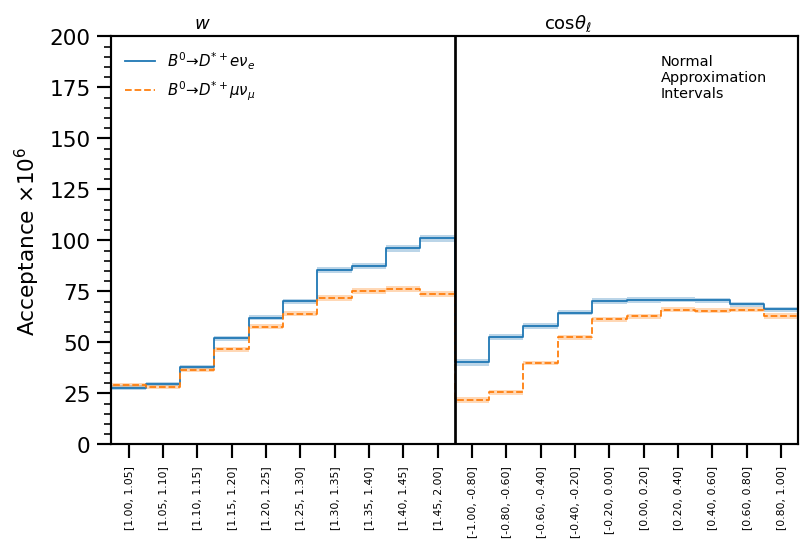

In [32]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for channel in channels:

    histogram = []
    histogram_unc = []
    for voi in fit_vois:
        bin_edges = copy(bin_edges_all[voi])
        query = f"SIG_ID in (4.1, 4.2) and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel} and {fit_range[0]} < {fit_variable} < {fit_range[1]}"
        
        # 3 a) Histogram the signal MC (you can query with df_mc.query(query) to select the signal MC. Use np.histogram, remember that we have pre-defined the bin via `bin_edges`, and that the weights are given in the column `__weight_overall__`.
        ###
        hist, _ = np.histogram(
            df_mc.query(query)[voi_mc[voi]],
            bins=bin_edges, 
            density=False,
            weights=df_mc.query(query)["__weight_overall__"],
           )
        histogram.append(hist)
        hist_unc, _ = np.histogram(
            df_mc.query(query)[voi_mc[voi]],
            bins=bin_edges, 
            density=False,
            weights=df_mc.query(query)["__weight_overall__"] ** 2,
           )
        histogram_unc.append(hist_unc)
        ###
    
    # Flatten the histogram(_unc) list we defined above.
    signal_mc_histogram = np.array(histogram).flatten()
    signal_mc_histogram_unc = np.array(histogram_unc).flatten()

    
    # 3 c) Why do we multiply here with 2 * N_BB * BR(B0 --> D* l nu) * tauBzero * bin_width? Explain each factor
    expected = unp.nominal_values(full_theory_bgl[channel] * 2 * N_BB.nominal_value * BR_GENERIC_MIXED.nominal_value * tauBzero * bin_widths["mixed"])
    
    acceptance_corrections[channel] = unp.uarray(
            signal_mc_histogram,
            signal_mc_histogram_unc ** 0.5
    ) / expected[:20]
    acceptance = unp.nominal_values(acceptance_corrections[channel])
    acceptance_unc = unp.std_devs(acceptance_corrections[channel])
    ax.step(range(-1,21), 1e6*np.array([acceptance[0], *acceptance, acceptance[-1]]), ls=linestyles[channel], where="mid", label=channel_label[channel], lw=1)
    ax.bar(
        range(0, 20),
        height=1e6 * 2 * acceptance_unc,
        bottom=1e6 * (acceptance - acceptance_unc),
        width=1, alpha=0.3,
    )

tmp = {}
for voi in fit_vois:
    tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
tmp = np.array([b for voi in fit_vois for b in tmp[voi]])

# We want to show all ticks...
ax.set_xticks(np.arange(len(tmp)))
# ... and label them with the respective list entries
ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlim(-0.5, 19.5)
ax.set_ylim(0, 200)
ax.axvline(9.5, color="black")

ax.text(0.8, 0.85, "Normal\nApproximation\nIntervals", fontsize=8, transform=ax.transAxes)
ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)

ax.set_ylabel(r"Acceptance $\times 10^6$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.savefig(f"{plotoutdir}/acceptance.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/acceptance.png", transparent=True)   
plt.show()
plt.close()

In [33]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 19.5)

    ax.axvline(9.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

# Unfolding

In [34]:
from academy.analysis.unfolding import extract_bs_spectrum

## Exercise 4: Migration Matrix

Next we want to unfold our background subtracted spectrum. For this we want to calculate the migration matrix. Use the pre-defined function below and fill out the function body.
The matrix should have the form `w Reco` on the "x-axis", and `w MC` on the "y-axis". (This can be done differently, but the follow-up code assumes this.

In [35]:
def determine_migration_martrix(df, bin_edges, col_mc, col_reco, weight_column="__weight_overall__"):
    df.loc[:, f"bins_{col_mc}"] = pd.cut(df[col_mc], bins=bin_edges, labels=range(len(bin_edges)-1))
    df.loc[:, f"bins_{col_reco}"] = pd.cut(df[col_reco], bins=bin_edges, labels=range(len(bin_edges)-1))
    
    return np.array([
        np.array([
            sum(df.query(f"bins_{col_reco} == {i_reco_bin} and bins_{col_mc} == {i_mc_bin}")[weight_column])
            for i_reco_bin in range(len(bin_edges)-1)
        ]) / sum(df.query(f"bins_{col_mc} == {i_mc_bin}")[weight_column])
        for i_mc_bin in range(len(bin_edges)-1)
    ]).transpose()


In [36]:
migration_matrices = {}

for channel in channels:
    migration_matrices[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        migration_matrices[channel][voi] = determine_migration_martrix(df_mc.query(query), bin_edges_all[voi], voi_mc[voi], voi)

In [37]:
full_migrations = {}

for channel in channels:
    n_bins = len(fit_vois)*10
    full_migration = np.zeros((n_bins, n_bins))
    for i, voi in enumerate(fit_vois):
        full_migration[i*10:(i+1)*10, i*10:(i+1)*10] = migration_matrices[channel][voi]
    full_migrations[channel] = full_migration

In [38]:
mc_distributions = {}

for channel in channels:
    mc_distributions[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        mc_distributions[channel][voi] = np.histogram(df_mc.query(query)[voi_mc[voi]], bins=bin_edges_all[voi], weights=df_mc.query(query)["__weight_overall__"])[0]
        
        
mc_reco_distributions = {}

for channel in channels:
    mc_reco_distributions[channel] = {}
    for voi in fit_vois:
        query = f"SIG_ID in (4.1, 4.2) and {fit_range[0]} < {fit_variable} < {fit_range[1]} and daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel}"
        mc_reco_distributions[channel][voi] = np.histogram(df_mc.query(query)[voi], bins=bin_edges_all[voi], weights=df_mc.query(query)["__weight_overall__"])[0]

In [39]:
full_mc_distributions = {}

for channel in channels:
    full_mc_distributions[channel] = np.concatenate(tuple(mc_distributions[channel][voi] for voi in fit_vois))
    
full_mc_reco_distributions = {}

for channel in channels:
    full_mc_reco_distributions[channel] = np.concatenate(tuple(mc_reco_distributions[channel][voi] for voi in fit_vois))

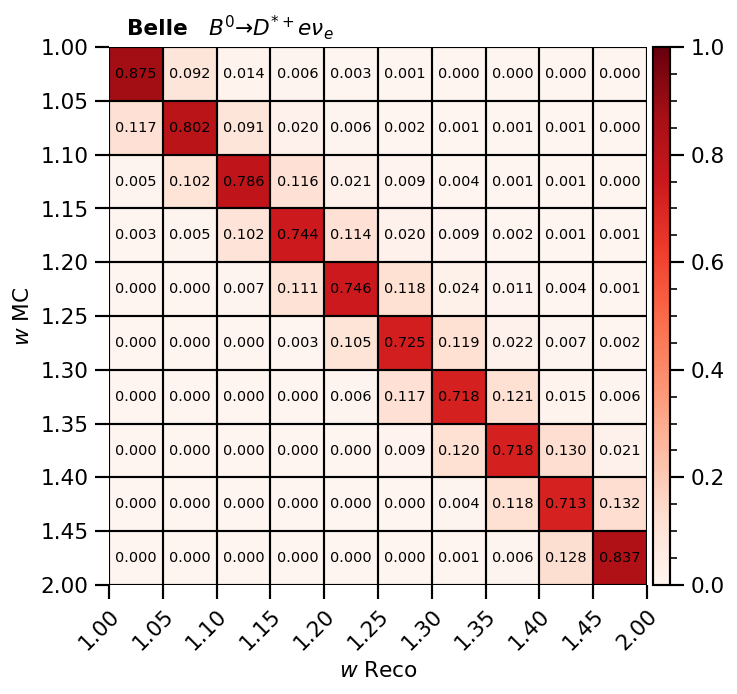

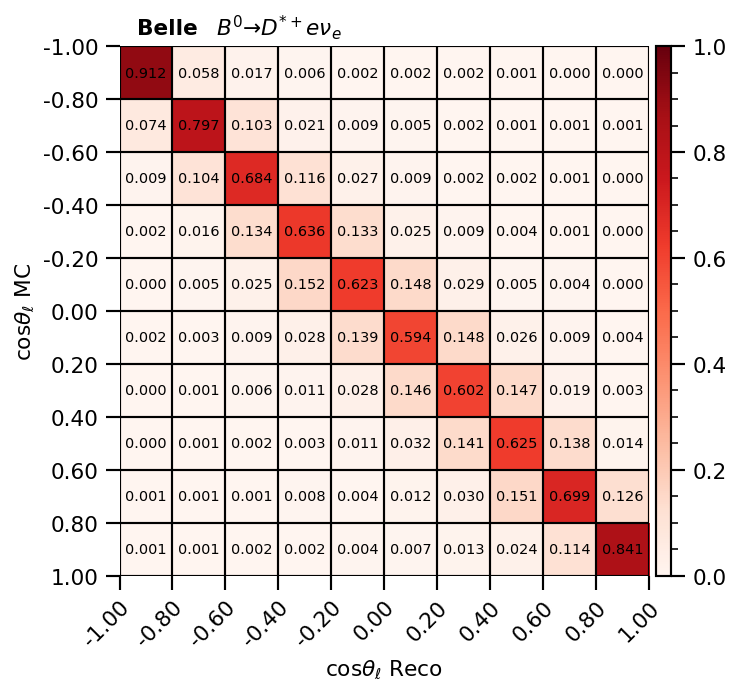

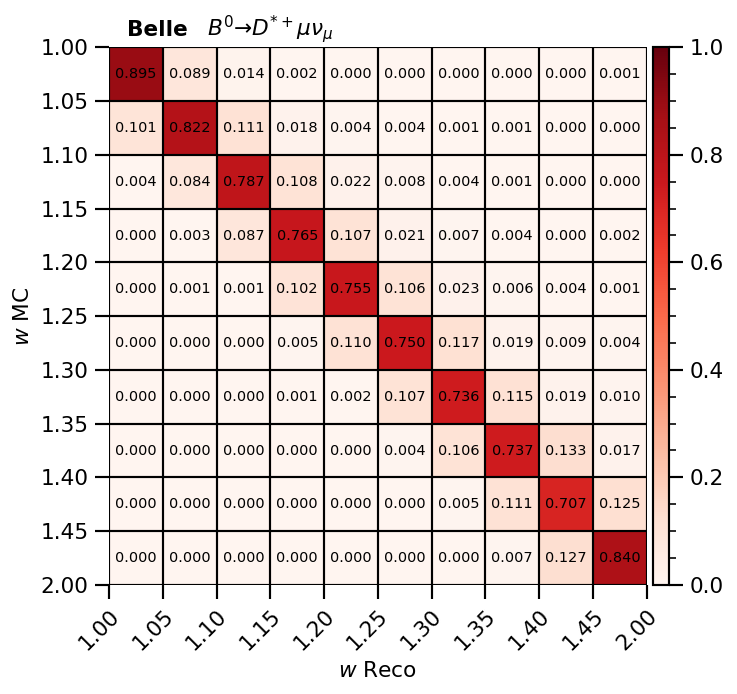

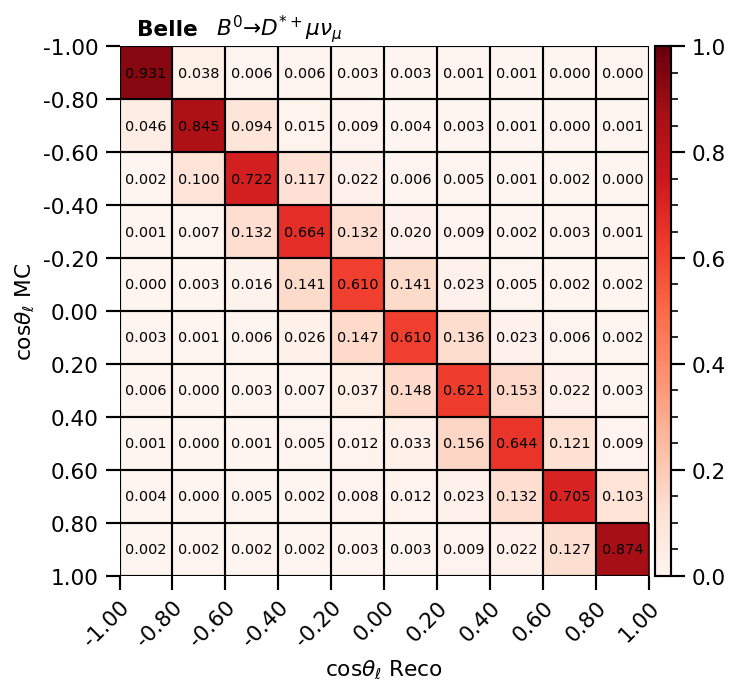

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for channel in channels:
    for voi in fit_vois:
        migration_matrix = migration_matrices[channel][voi]
        fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4 / 0.8))
        im = ax.imshow(migration_matrix, vmin=0, vmax=1, cmap=plt.get_cmap("Reds"))

        # We want to show all ticks...
        bin_edges = bin_edges_all[voi]
        ax.set_xticks(np.arange(len(bin_edges)) - 0.5)
        ax.set_yticks(np.arange(len(bin_edges)) - 0.5)
        # ... and label them with the respective list entries
        ax.set_xticklabels([f"{x:.2f}" for x in bin_edges])
        ax.set_yticklabels([f"{x:.2f}" for x in bin_edges])

        ax.set_xlabel(f"{voi_labels[voi]} Reco")
        ax.set_ylabel(f"{voi_labels[voi]} MC")

        # Create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
        #cbar.ax.set_ylabel("...", rotation=-90, va="center")

        # Turn spines off and create white grid.
        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.set_xticks(np.arange(migration_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(migration_matrix.shape[0]+1)-.5, minor=True)
        ax.grid(which="major", color="black", linestyle='-', linewidth=1.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(len(bin_edges)-1):
            for j in range(len(bin_edges)-1):
                text = ax.text(j, i, f"{migration_matrix[i, j]:.3f}",
                               ha="center", va="center", color="black", fontsize=8)


        add_watermark(ax, channel_label[channel])
        plt.tight_layout()
        plt.savefig(f"{plotoutdir}/migration_matrix_channel{channel}_{voi}.pdf", transparent=True)
        plt.savefig(f"{plotoutdir}/migration_matrix_channel{channel}_{voi}.png", transparent=True) 
        plt.show()
        plt.close()

# Exercise 5: Apply Unfolding and Acceptance Correction

Below is the background subtracted spectrum from the previous session.

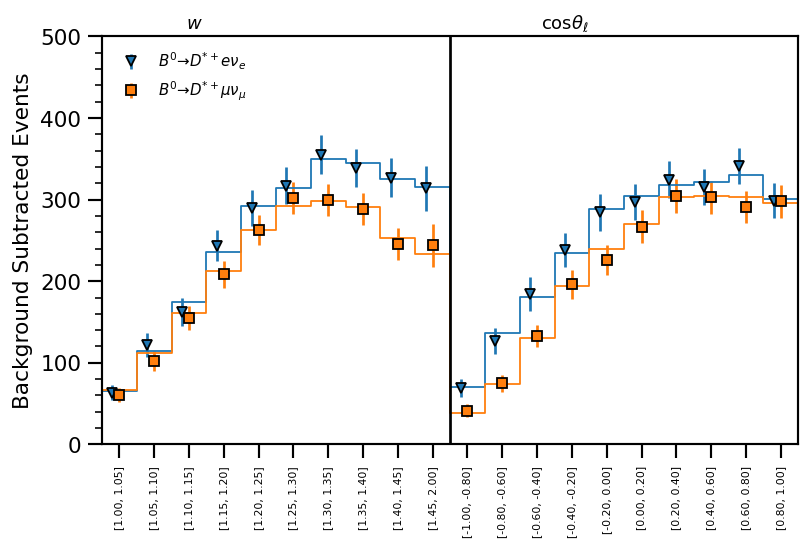

In [41]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate([15, 16]):
    
    result = results[channel]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
        
    )
    
    histogram = full_mc_reco_distributions[channel]
    ax.step(range(-1,21), np.array([histogram[0], *histogram, histogram[-1]]), 
            ls="solid", lw=1, where="mid", color=plt.gca().lines[-1].get_color())

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 500)
ax.set_ylabel("Background Subtracted Events")


plt.tight_layout()
plt.savefig(f"{plotoutdir}/bs_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/bs_spectrum.png", transparent=True)   
plt.show()
plt.close()

Ex. 5a) Apply the unfolding to the background subtracted yields

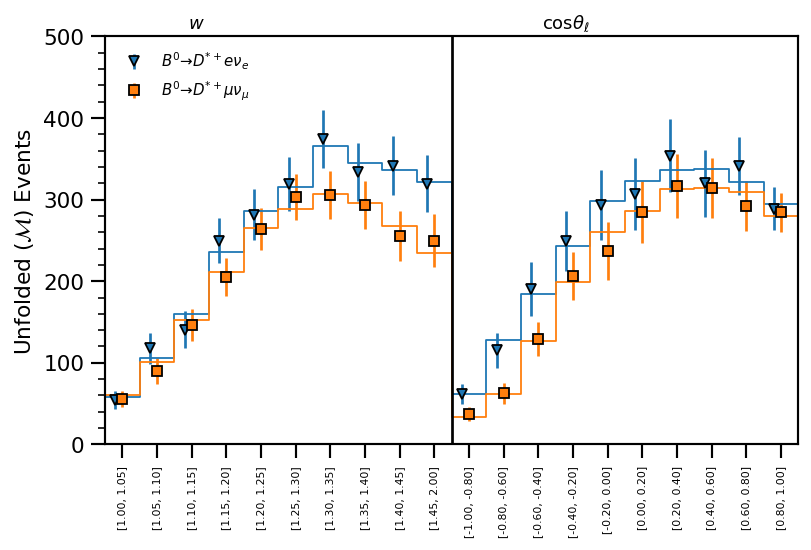

In [42]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate([15, 16]):
    
    # define inv_m (our unfolding matrix)
    # inv_m = ...
    inv_m = np.linalg.inv(full_migrations[channel])
    
    # unfold our background subtracted spectrum. The results are available in results[channel] for each channel
    # result = ...
    result = inv_m @ results[channel]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
        
    )
    
    histogram = full_mc_distributions[channel]
    ax.step(range(-1,21), np.array([histogram[0], *histogram, histogram[-1]]), 
            ls="solid", lw=1, where="mid", color=plt.gca().lines[-1].get_color())
        

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 500)
ax.set_ylabel(r"Unfolded ($\mathcal{M}$) Events")

plt.tight_layout()
plt.savefig(f"{plotoutdir}/unfolded_m_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/unfolded_m_spectrum.png", transparent=True)
plt.show()
plt.close()

In [43]:
def plot_theory(ax, full_theory, bin_widths):
    theory = full_theory[15] * bin_widths["mixed"]
    ax.step(range(-1,21), 1e15*np.array([theory[0], *theory[:20], theory[-1]]), 
            lw=1, ls="-", where="mid", color="black", label="$B^0$ BGL Theory")
    return ax

In [44]:
def get_factor(channel):
    factor = (2*N_BB.nominal_value * BR_GENERIC_MIXED.nominal_value) * tauBzero
    return factor * np.ones(20)

Ex. 5b) Apply the unfolding *and* acceptance correction.

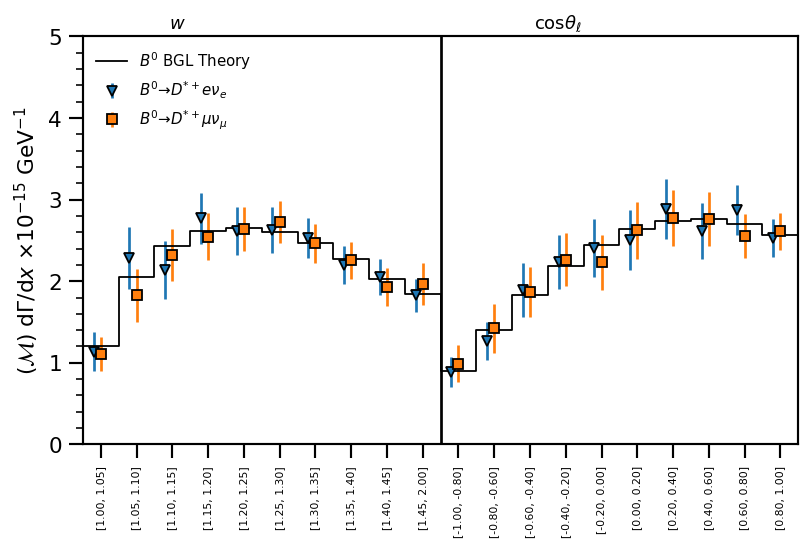

In [45]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

for i, channel in enumerate(channels):
    
    # define inv_m (our unfolding matrix)
    # inv_m = ...
    inv_m = np.linalg.inv(full_migrations[channel])
    
    # unfold our background subtracted spectrum. The results are available in results[channel] for each channel
    # result = ...
    result = inv_m @ results[channel]
    
    factor = get_factor(channel) # This number translates yields to rates. The you have to divide by that number.
    acceptance = acceptance_corrections[channel] # This is our determined acceptance function
    # divide the result by both the factor and the acceptance correction
    result = [r / a / f for r, a, f in zip(result, acceptance_corrections[channel], factor)]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 20)],
        y=1e15*unp.nominal_values(result),
        yerr=1e15*unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
    )

plot_theory(ax, full_theory_bgl, bin_widths)
make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 5)
ax.set_ylabel(r"($\mathcal{M}$) $\mathrm{d} \Gamma / \mathrm{d}x$ $\times 10^{-15}$ GeV$^{-1}$")

plt.tight_layout()
plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum.pdf", transparent=True)
plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum.png", transparent=True)   
plt.show()
plt.close()

In [46]:
result

[1.1082706802312891e-15+/-2.0756861396527764e-16,
 1.828661427107825e-15+/-3.250790987608767e-16,
 2.3231460153891177e-15+/-3.210700869869871e-16,
 2.5459229307164632e-15+/-2.9224490404061167e-16,
 2.642894766608028e-15+/-2.674282288790401e-16,
 2.7270952268904473e-15+/-2.5951839151817866e-16,
 2.464236955395463e-15+/-2.3832464736702216e-16,
 2.255395693609525e-15+/-2.285488883115092e-16,
 1.931583129053967e-15+/-2.331882248053387e-16,
 1.961371042489862e-15+/-2.580429495009301e-16,
 9.871130026676931e-16+/-2.2798681198088714e-16,
 1.422009942106202e-15+/-2.9983349416217844e-16,
 1.8628529998929604e-15+/-3.051831818690077e-16,
 2.2631842688798375e-15+/-3.2507714848174077e-16,
 2.231105037112603e-15+/-3.3704845212227265e-16,
 2.6228969928036714e-15+/-3.523761110949056e-16,
 2.7721705701597208e-15+/-3.460154601608323e-16,
 2.7624924248448804e-15+/-3.2574792848623543e-16,
 2.5537391107196282e-15+/-2.688243141696252e-16,
 2.609912503197727e-15+/-2.2283757663896077e-16]

# Everything at once

Here we basically re-do everything we did above, with the exception that we do it globally instead of channel by channel. This is useful to properly carry the systematic affects in the unfolding process. Conceptually this is the same thing.

In [47]:
full_yields = yields['$\nu_\mathrm{sig}$'].values

In [48]:
full_covariance = np.outer(
    yields['$\sigma_\mathrm{tot}$'].values, yields['$\sigma_\mathrm{tot}$'].values
) * pd.read_pickle(os.path.join(f"output/Fitting/{data_type}", f"correlation_full.pkl"))

In [49]:
fit_yields = np.array(correlated_values(full_yields, full_covariance))

In [50]:
inv_m = scipy.linalg.block_diag(*[np.linalg.inv(full_migrations[channel]) for channel in channels])
acceptance_correction = np.array([acceptance_corrections[channel] for channel in channels]).flatten()
factor = np.array([get_factor(channel) for channel in channels]).flatten()
bw = bin_widths["mixed"]

unfolded = inv_m @ fit_yields
corrected =  np.array([r / a / f for r, a, f in zip(unfolded, acceptance_correction, factor)])

In [51]:
np.save(os.path.join(plotoutdir, f"minv_central_values_full.npy"), unp.nominal_values(corrected))

In [52]:
np.save(os.path.join(plotoutdir, f"minv_covariance_full.npy"), uncertainties.covariance_matrix(corrected))

In [53]:
corrected

array([1.1353579062605709e-15+/-2.3638396229570305e-16,
       2.2873844033515983e-15+/-3.804153114085393e-16,
       2.1376711909022846e-15+/-3.5040093493701376e-16,
       2.7697437844434208e-15+/-3.1364942673235505e-16,
       2.6107154588094894e-15+/-2.9469626541754454e-16,
       2.630232658793549e-15+/-2.786711829830693e-16,
       2.5311687477590417e-15+/-2.464993391311142e-16,
       2.2022734366436323e-15+/-2.3403723294869137e-16,
       2.0540543385576747e-15+/-2.2088990030114173e-16,
       1.8255224809268513e-15+/-2.0175485682660566e-16,
       8.836474757353765e-16+/-1.8102961984897463e-16,
       1.2623968433797992e-15+/-2.344710853507226e-16,
       1.8972059394939704e-15+/-3.308743230157914e-16,
       2.234161047837639e-15+/-3.3199928088954406e-16,
       2.4036653303302163e-15+/-3.5556300976140064e-16,
       2.5057440964614536e-15+/-3.651515342392012e-16,
       2.8830977673758237e-15+/-3.653403330632684e-16,
       2.614087811469285e-15+/-3.4176814693146234e-16,
   